## **Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

import csv
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Flatten, MaxPooling2D, Dense
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# setting random seeds to reduce the amount of randomness in the neural net weights and results

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
!unzip val.zip

In [ ]:
!unzip train.zip

## **Define Age Classes**

In [5]:
def class_labels_reassign(age):
  if age == '0-14':
    return 0
  if age == '15-24':
    return 1
  if age == '25-64':
    return 2
  if age == '65-100':
    return 3

## **Extracting age labels - test data**

In [4]:
ages = [] # list to store age labels

with open('/content/val_csv.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
      if line_count == 0:
        line_count += 1
      else:
        rowJson = json.loads(row[6])
        ages.append(rowJson["age"])
        line_count += 1

## **Creating test data**

In [6]:
path = '/content/val' # path to the directory with test images
x_test = [] # images
y_test = [] # labels

i = 0
for img in os.listdir(path):
  i = i + 1
  img = cv2.imread(str(path) + '/' + str(img))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to gray scale
  img = cv2.resize(img, (100, 100))
  x_test.append(np.array(img))
  y_test.append(np.array(class_labels_reassign(ages[i - 1])))

x_test = np.array(x_test) # convert the list of image arrays to a numpy array
y_test = np.array(y_test, np.uint64) # convert the list of labels to a numpy array of uint64 type

## **Extracting age labels - training data**

In [7]:
ages = [] # list to store age labels

with open('/content/train_csv.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
      if line_count == 0:
        line_count += 1
      else:
        rowJson = json.loads(row[6])
        ages.append(rowJson["age"])
        line_count += 1

## **Creating training data**

In [8]:
path = '/content/train'
x_train = [] # images
y_train = [] # labels

i = 0
for img in os.listdir(path):
  i = i + 1
  img = cv2.imread(str(path) + '/' + str(img))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale
  img = cv2.resize(img, (100, 100))
  x_train.append(np.array(img))
  y_train.append(np.array(class_labels_reassign(ages[i - 1])))

x_train = np.array(x_train) # convert the list of image arrays to a numpy array
y_train = np.array(y_train, np.uint64) # convert the list of labels to a numpy array of uint64 type

In [9]:
len(x_test)

25

In [10]:
len(x_train)

90

In [11]:
len(y_train)

90

In [12]:
len(y_test)

25

## **Define CNN Architecture**

In [13]:
input = Input(shape = (100,100,1)) # define the input shape for the model - indicating that the input images are grayscale with dimensions 100x100

# convolutional layers (conv1, conv2, conv3, conv4 with 32, 64, 128, and 256 filters, respectively) with dropout and activation
conv1 = Conv2D(32, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)

conv2 = Conv2D(64, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)

conv3 = Conv2D(128, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)

conv4 = Conv2D(256, (3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)

flatten = Flatten()(pool4) # flatten the output of the last convolutional layer

dense_1 = Dense(128, activation='relu')(flatten) # fully connected layer with ReLU activation

drop_1 = Dropout(0.2)(dense_1) # dropout layer - to prevent overfitting

output = Dense(4, activation="sigmoid")(drop_1) # output layer, 4 - number of possible outputs

In [14]:
model = Model(inputs=input,outputs=output) # create a model by specifying the input and output layers
model.compile(optimizer="adam",loss=["sparse_categorical_crossentropy"],metrics=['accuracy']) # compile the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      320       
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                             

In [15]:
model_path = './output/age_model.h5' # path where the model will be saved
# sets the metric to monitor for saving the best model, saves only the best model based on the monitored metric, the entire model will be saved
checkpointer = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only = True,
                               save_weights_only=False, mode='auto', save_freq='epoch')
callback_list = [checkpointer]

## **Training the model**

In [16]:
save = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, callbacks=[callback_list])

Epoch 1/30
3/3 [==============================] - ETA: 0s - loss: 24.2521 - accuracy: 0.7444
Epoch 1: loss improved from inf to 24.25207, saving model to ./output/age_model.h5
3/3 [==============================] - 13s 615ms/step - loss: 24.2521 - accuracy: 0.7444 - val_loss: 38.6632 - val_accuracy: 0.7200
Epoch 2/30
1/3 [=========>....................] - ETA: 0s - loss: 12.4021 - accuracy: 0.9375
Epoch 2: loss improved from 24.25207 to 7.62088, saving model to ./output/age_model.h5
3/3 [==============================] - 0s 73ms/step - loss: 7.6209 - accuracy: 0.8333 - val_loss: 22.3480 - val_accuracy: 0.7200
Epoch 3/30
1/3 [=========>....................] - ETA: 0s - loss: 5.7156 - accuracy: 0.9375
Epoch 3: loss improved from 7.62088 to 5.52857, saving model to ./output/age_model.h5
3/3 [==============================] - 0s 68ms/step - loss: 5.5286 - accuracy: 0.9444 - val_loss: 12.3771 - val_accuracy: 0.7200
Epoch 4/30
1/3 [=========>....................] - ETA: 0s - loss: 1.9170 - a

## **Train and test loss and accuracy**

In [17]:
# checking the train and test loss and accuracy values from the neural network above

train_loss = save.history['loss']
test_loss = save.history['val_loss']
train_accuracy = save.history['accuracy']
test_accuracy = save.history['val_accuracy']

## **Line chart**

Text(0.5, 0.92, 'Lineplots showing loss and accuracy of CNN model by epochs')

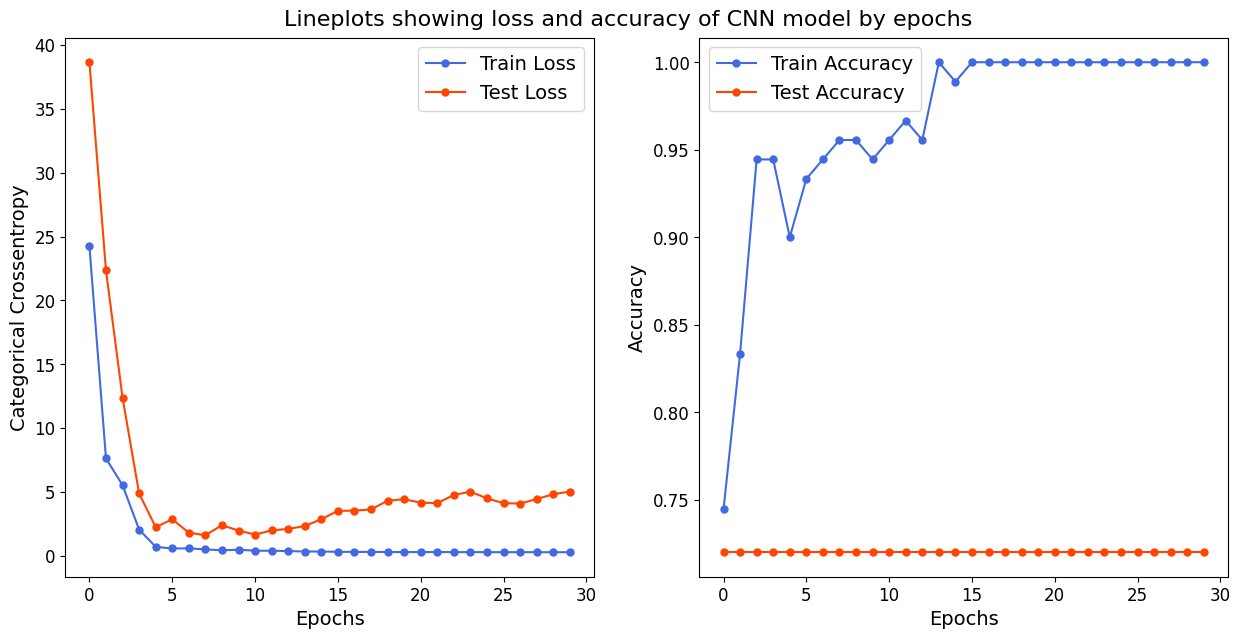

In [18]:
# plotting a line chart to visualize the loss and accuracy values by epochs

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

## **Evaluation of the model**

In [ ]:
# Evaluate the gender model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

# Print the evaluation results
print(f'Test Loss: {loss:.2f}')
print(f'Test Accuracy: {accuracy:.2f}')